In [1]:
import torch
from diffusers import StableDiffusion3Pipeline
%matplotlib inline

/users/gmongaras/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-06 08:29:13.182588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 08:29:14.004673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /users/gmongaras/cuda-11.8/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /hpc/mp/apps/conda did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.4.1+cu121 with CUDA 1201 (you have 2.5.0+cu118)
    Python  3.10.15 (you have 3.10.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [2]:
# Read token from .env file
with open(".env", "r") as f:
    token = f.read().strip()

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16, cache_dir="./cache", token=token)
pipe = pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]


In [3]:
# Reimport attention processor
import CustomProcessor2 as CustomProcessor2
import importlib
importlib.reload(CustomProcessor2)
CustomProcessor2 = CustomProcessor2.CustomProcessor

In [4]:
# Get stable diffusion 3 config
config = pipe.transformer.config

# Replace attention in stable diffusion with the imported one
num_skip = 0
for i, layer in enumerate(pipe.transformer.transformer_blocks):
    if i >= num_skip:
        layer.attn.set_processor(CustomProcessor2())

In [5]:
# Customer feed forward
import torch
from torch import nn
from typing import Optional
from diffusers.models.activations import GEGLU, GELU, ApproximateGELU, FP32SiLU, SwiGLU

class FeedForward(nn.Module):
    r"""
    A feed-forward layer.

    Parameters:
        dim (`int`): The number of channels in the input.
        dim_out (`int`, *optional*): The number of channels in the output. If not given, defaults to `dim`.
        mult (`int`, *optional*, defaults to 4): The multiplier to use for the hidden dimension.
        dropout (`float`, *optional*, defaults to 0.0): The dropout probability to use.
        activation_fn (`str`, *optional*, defaults to `"geglu"`): Activation function to be used in feed-forward.
        final_dropout (`bool` *optional*, defaults to False): Apply a final dropout.
        bias (`bool`, defaults to True): Whether to use a bias in the linear layer.
    """

    def __init__(
        self,
        dim: int,
        dim_out: Optional[int] = None,
        mult: int = 4,
        dropout: float = 0.0,
        activation_fn: str = "gelu",
        final_dropout: bool = False,
        inner_dim=None,
        bias: bool = True,
    ):
        super().__init__()
        if inner_dim is None:
            inner_dim = int(dim * mult)
        dim_out = dim_out if dim_out is not None else dim

        if activation_fn == "gelu":
            act_fn = GELU(dim, inner_dim, bias=bias)
        if activation_fn == "gelu-approximate":
            act_fn = GELU(dim, inner_dim, approximate="tanh", bias=bias)
        elif activation_fn == "geglu":
            act_fn = GEGLU(dim, inner_dim, bias=bias)
        elif activation_fn == "geglu-approximate":
            act_fn = ApproximateGELU(dim, inner_dim, bias=bias)
        elif activation_fn == "swiglu":
            act_fn = SwiGLU(dim, inner_dim, bias=bias)

        self.net = nn.ModuleList([])
        # project in
        self.net.append(act_fn)
        # project dropout
        self.net.append(nn.Dropout(dropout))
        # project out
        self.net.append(nn.Linear(inner_dim, dim_out, bias=bias))
        # FF as used in Vision Transformer, MLP-Mixer, etc. have a final dropout
        if final_dropout:
            self.net.append(nn.Dropout(dropout))

    def forward(self, hidden_states: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        # Save pre tokens
        self.pre_tokens.append(hidden_states.detach().cpu())

        for module in self.net:
            hidden_states = module(hidden_states)

        # Save post tokens
        self.post_tokens.append(hidden_states.detach().cpu())

        return hidden_states
    

# Replace feed forward in stable diffusion with the imported one
for i, layer in enumerate(pipe.transformer.transformer_blocks):
    if i >= num_skip:
        old_state_dict = layer.ff.state_dict().copy()
        device = layer.ff.net[0].proj.weight.device
        dtype = layer.ff.net[0].proj.weight.dtype
        layer.ff = FeedForward(
            dim=layer.ff.net[0].proj.weight.shape[1],
            dim_out=layer.ff.net[2].weight.shape[0],
            inner_dim=layer.ff.net[0].proj.weight.shape[0],
            activation_fn="gelu",
        )
        layer.ff.load_state_dict(old_state_dict)
        layer = layer.to("cuda").to(dtype)
        del old_state_dict

In [2]:
# Reset all similarity scores
for layer in pipe.transformer.transformer_blocks:
    layer.attn.processor.query_sim = []
    layer.attn.processor.key_sim = []
    layer.attn.processor.value_sim = []

# Reset tokens in the layer
for layer in pipe.transformer.transformer_blocks:
    layer.attn.processor.pre_tokens = []
    layer.attn.processor.post_tokens = []
    layer.ff.pre_tokens = []
    layer.ff.post_tokens = []

generator = torch.Generator(device="cuda").manual_seed(0)
image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    generator=generator
).images[0]
image

NameError: name 'pipe' is not defined

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

query_sim = []
key_sim = []
value_sim = []
for layer in pipe.transformer.transformer_blocks:
    query_sim.append(layer.attn.processor.query_sim)
    key_sim.append(layer.attn.processor.key_sim)
    value_sim.append(layer.attn.processor.value_sim)

In [8]:
query_avg_over_time = []
key_avg_over_time = []
value_avg_over_time = []
for i in range(len(query_sim)):
    query_avg_over_time.append(np.concatenate(query_sim[i]).reshape(-1))
    key_avg_over_time.append(np.concatenate(key_sim[i]).reshape(-1))
    value_avg_over_time.append(np.concatenate(value_sim[i]).reshape(-1))

In [9]:
# The sizes of the arrays are massive. Sample 10_000 elements from each
def sample(arr):
    return np.random.choice(arr, 100_000)
query_avg_over_time = [sample(arr) for arr in query_avg_over_time]
key_avg_over_time = [sample(arr) for arr in key_avg_over_time]
value_avg_over_time = [sample(arr) for arr in value_avg_over_time]

/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

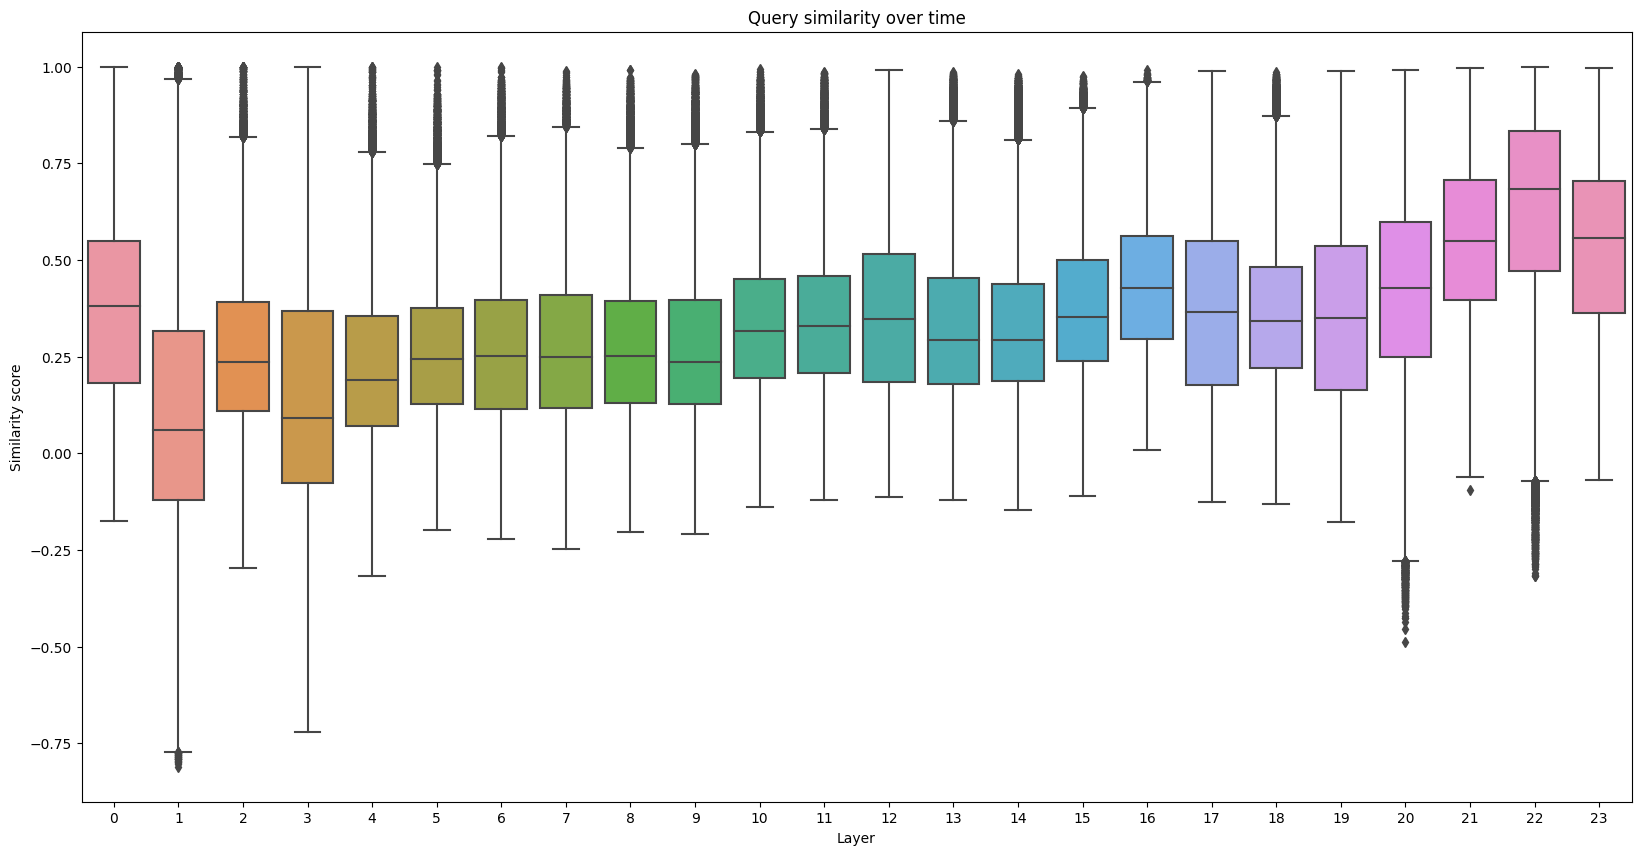

/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

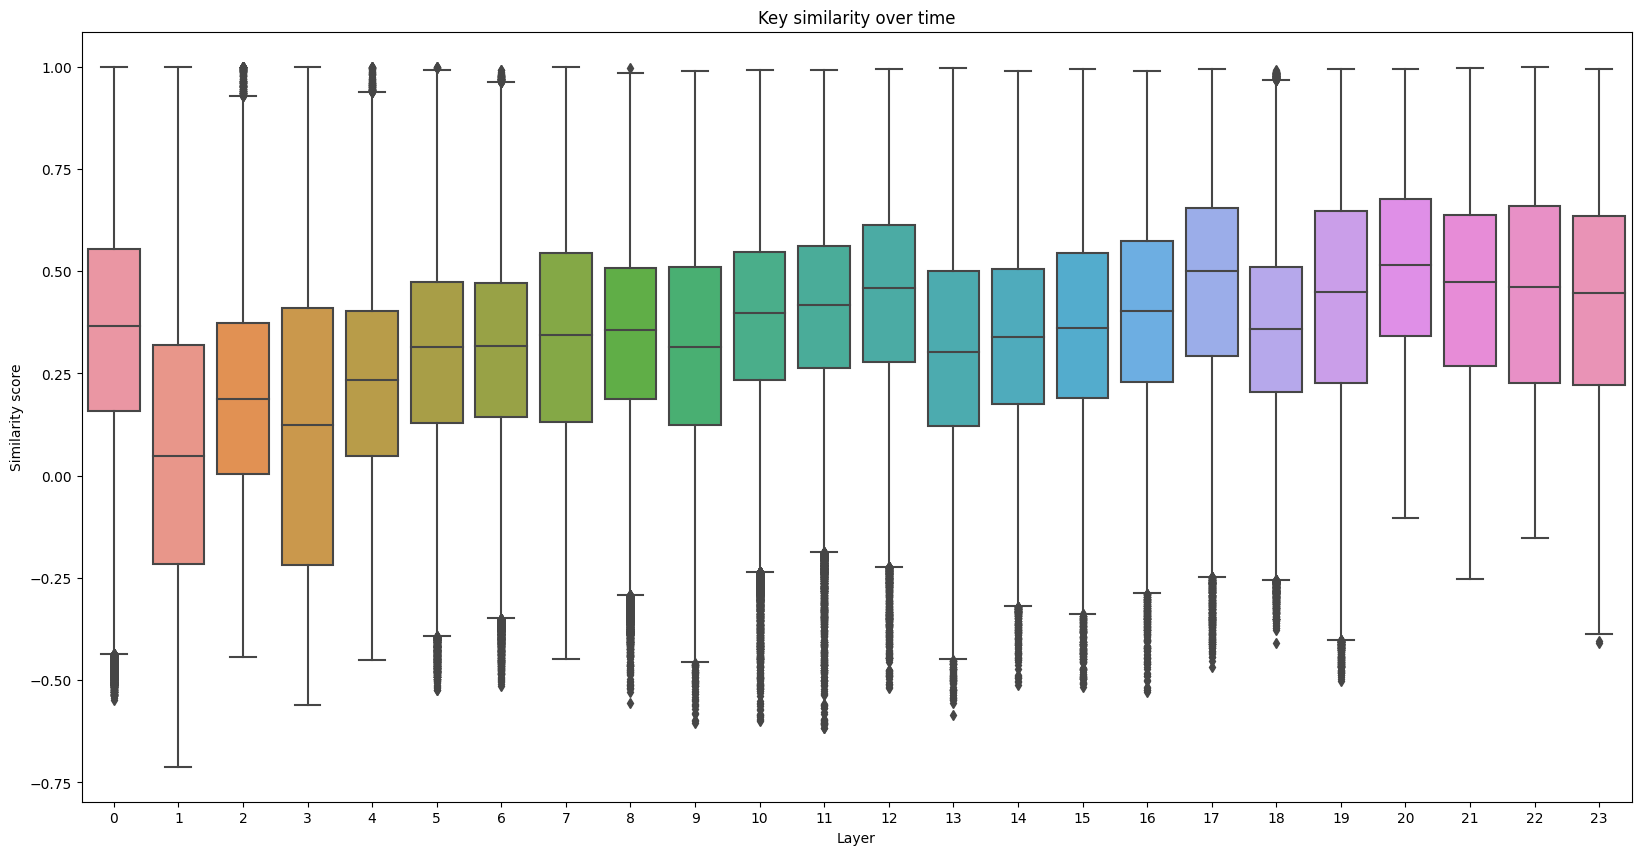

/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

Text(0.5, 1.0, 'Value similarity over time')

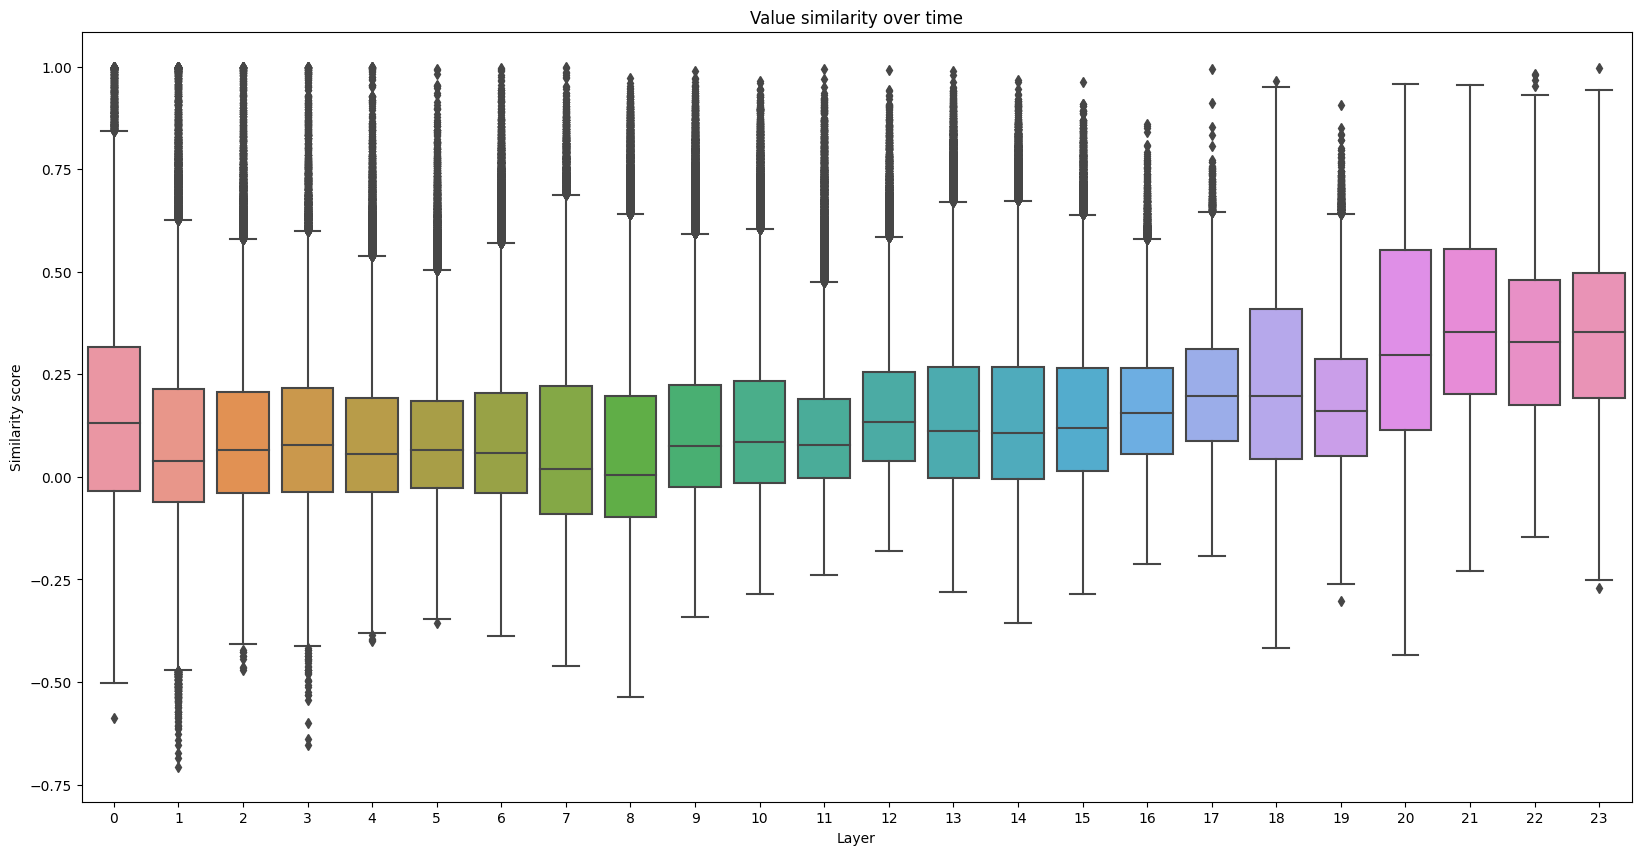

In [10]:
# Box plot of similarity scores. The x axis ranges over the layers of the transformer, and the y axis ranges over the similarity scores.
plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(query_avg_over_time).T)
plt.xlabel("Layer")
plt.ylabel("Similarity score")
plt.title("Query similarity over time")
plt.show()

plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(key_avg_over_time).T)
plt.xlabel("Layer")
plt.ylabel("Similarity score")
plt.title("Key similarity over time")
plt.show()

plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(value_avg_over_time).T)
plt.xlabel("Layer")
plt.ylabel("Similarity score")
plt.title("Value similarity over time")

In [11]:
query_avg_over_layers = [[] for i in range(0, len(query_sim[0]))]
key_avg_over_layers = [[] for i in range(0, len(query_sim[0]))]
value_avg_over_layers = [[] for i in range(0, len(query_sim[0]))]
for i in range(len(query_sim)):
    for j in range(len(query_sim[i])):
        query_avg_over_layers[j].append(query_sim[i][j])
        key_avg_over_layers[j].append(key_sim[i][j])
        value_avg_over_layers[j].append(value_sim[i][j])

In [12]:
query_avg_over_layers = [np.concatenate(query_avg_over_layers[i]).reshape(-1) for i in range(len(query_avg_over_layers))]
key_avg_over_layers = [np.concatenate(key_avg_over_layers[i]).reshape(-1) for i in range(len(key_avg_over_layers))]
value_avg_over_layers = [np.concatenate(value_avg_over_layers[i]).reshape(-1) for i in range(len(value_avg_over_layers))]

In [13]:
query_avg_over_layers = [sample(arr) for arr in query_avg_over_layers]
key_avg_over_layers = [sample(arr) for arr in key_avg_over_layers]
value_avg_over_layers = [sample(arr) for arr in value_avg_over_layers]

/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

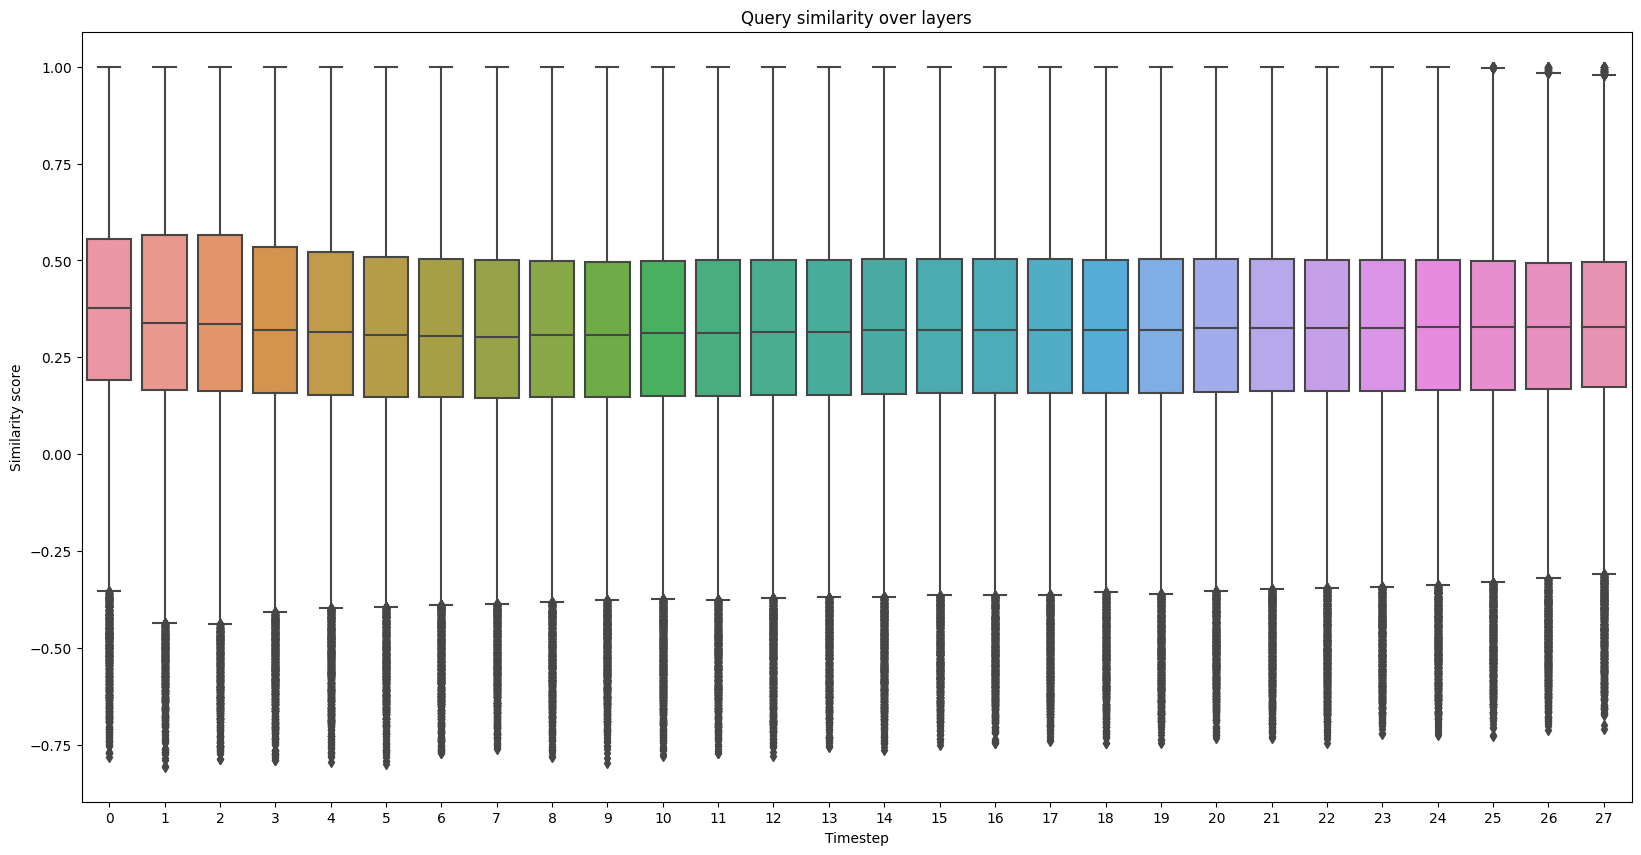

/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

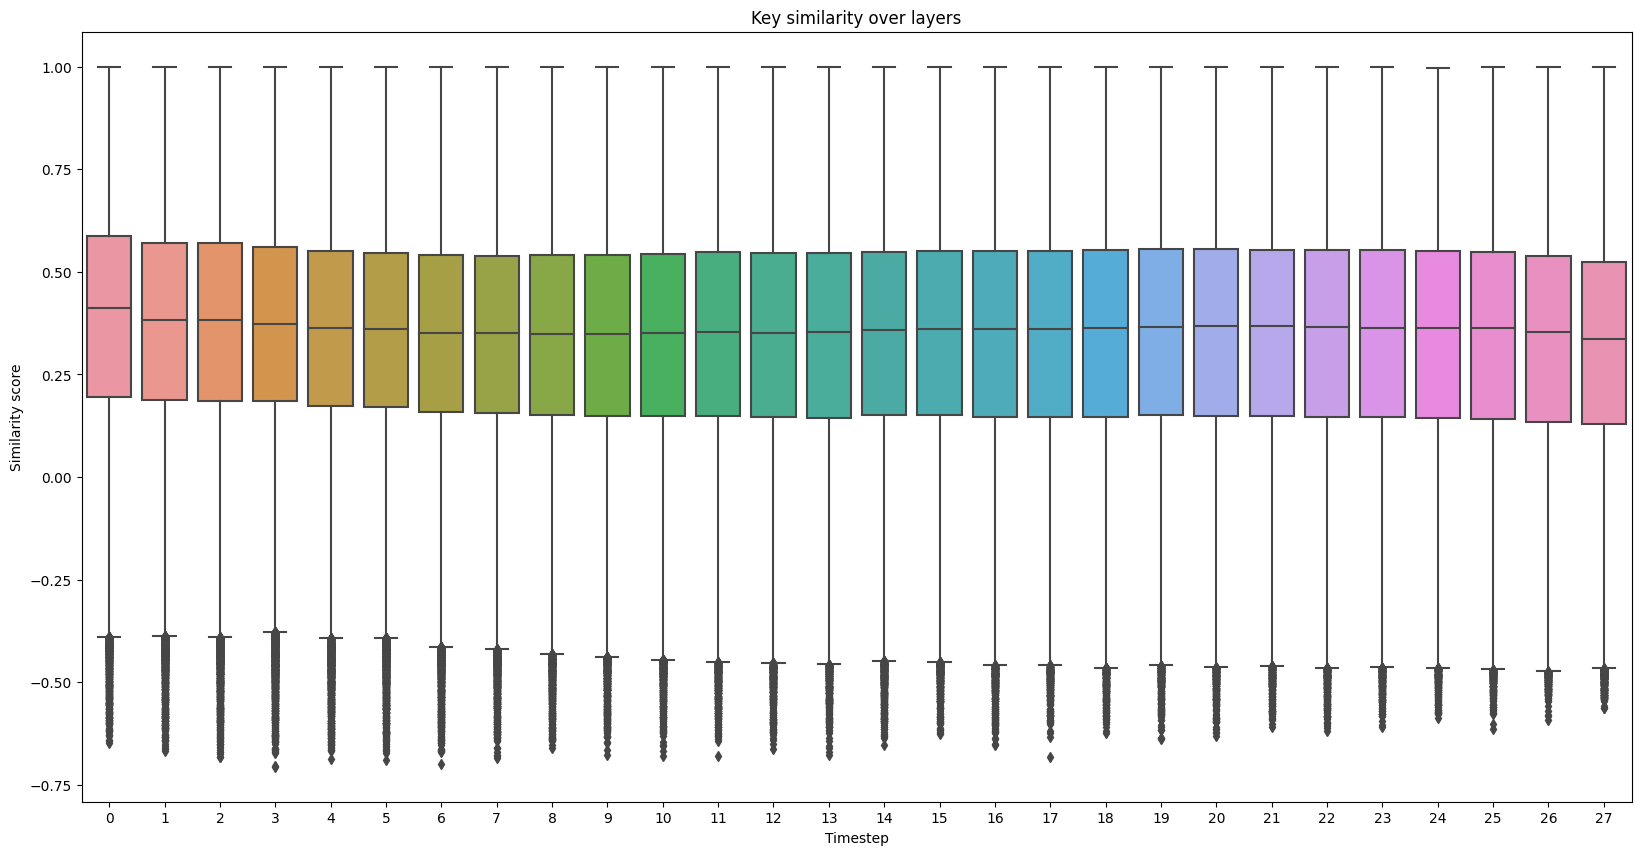

/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

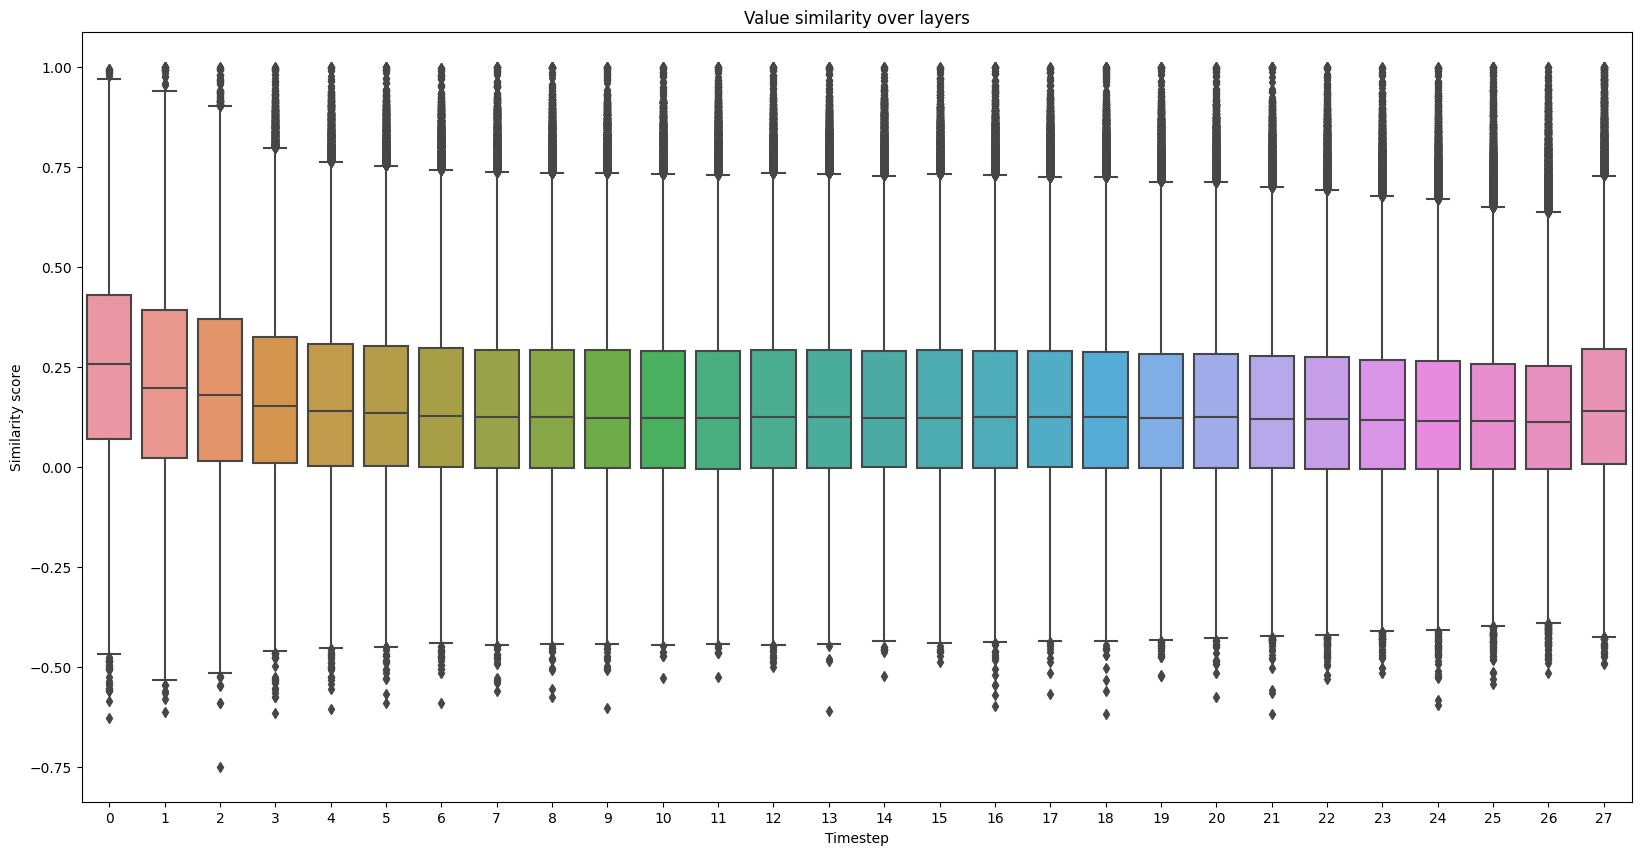

In [14]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(query_avg_over_layers).T)
plt.xlabel("Timestep")
plt.ylabel("Similarity score")
plt.title("Query similarity over layers")
plt.show()

plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(key_avg_over_layers).T)
plt.xlabel("Timestep")
plt.ylabel("Similarity score")
plt.title("Key similarity over layers")
plt.show()

plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(value_avg_over_layers).T)
plt.xlabel("Timestep")
plt.ylabel("Similarity score")
plt.title("Value similarity over layers")
plt.show()

In [19]:
# Get all pre and post tokens
pre_tokens = [] # (num_layers, timesteps, seq_len, dim)
post_tokens = [] # (num_layers, timesteps, seq_len, dim)
pre_tokens_ff = [] # (num_layers, timesteps, seq_len, dim)
post_tokens_ff = [] # (num_layers, timesteps, seq_len, dim)
for layer in pipe.transformer.transformer_blocks:
    pre_tokens.append(torch.stack(layer.attn.processor.pre_tokens)[:, 0])
    post_tokens.append(torch.stack(layer.attn.processor.post_tokens)[:, 0])
    pre_tokens_ff.append(torch.stack(layer.ff.pre_tokens)[:, 0])
    post_tokens_ff.append(torch.stack(layer.ff.post_tokens)[:, 0])

In [20]:
# Compute the difference between pre and post tokens
similarity = []
similarity_ff = []
for i in range(len(pre_tokens)):
    similarity.append((torch.nn.functional.normalize(pre_tokens[i], p=2, dim=-1)*torch.nn.functional.normalize(post_tokens[i], p=2, dim=-1)).sum(-1))
    similarity_ff.append((torch.nn.functional.normalize(pre_tokens_ff[i], p=2, dim=-1)*torch.nn.functional.normalize(post_tokens_ff[i], p=2, dim=-1)).sum(-1))

In [23]:
# Combine over layers (avg over time)
similarity_over_time = torch.cat(similarity, dim=-1)
similarity_over_time_ff = torch.cat(similarity_ff, dim=-1)

# Combine over time (avg over layers)
similarity_over_layers = []
for i in range(len(similarity)):
    similarity_over_layers.append(similarity[i].reshape(-1))
similarity_over_layers = torch.stack(similarity_over_layers)
similarity_over_layers_ff = []
for i in range(len(similarity_ff)):
    similarity_over_layers_ff.append(similarity_ff[i].reshape(-1))
similarity_over_layers_ff = torch.stack(similarity_over_layers_ff)

/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

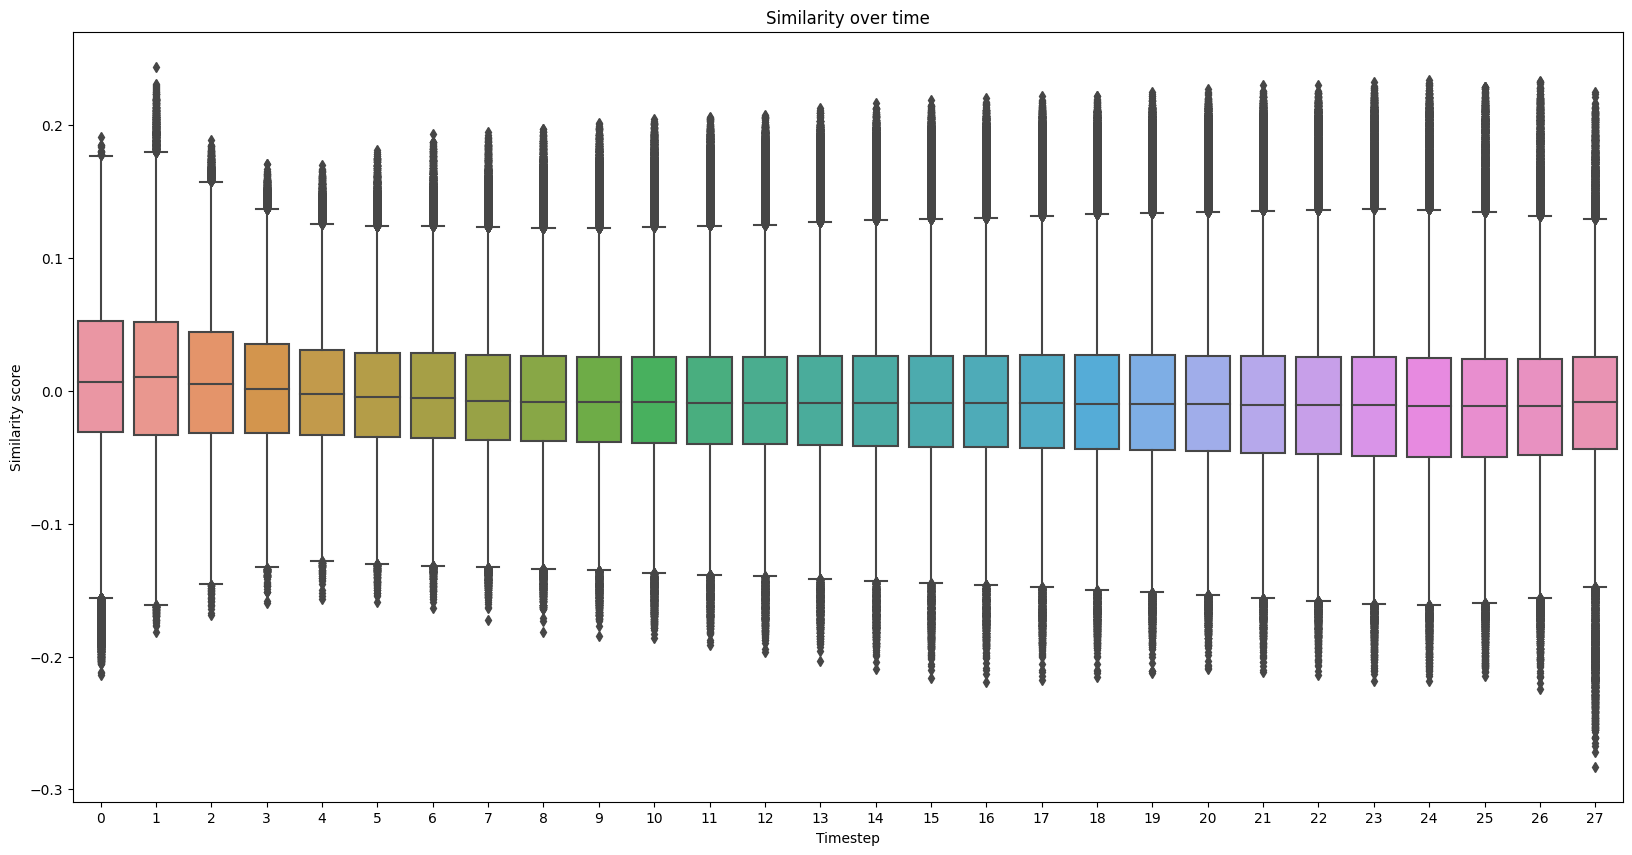

/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

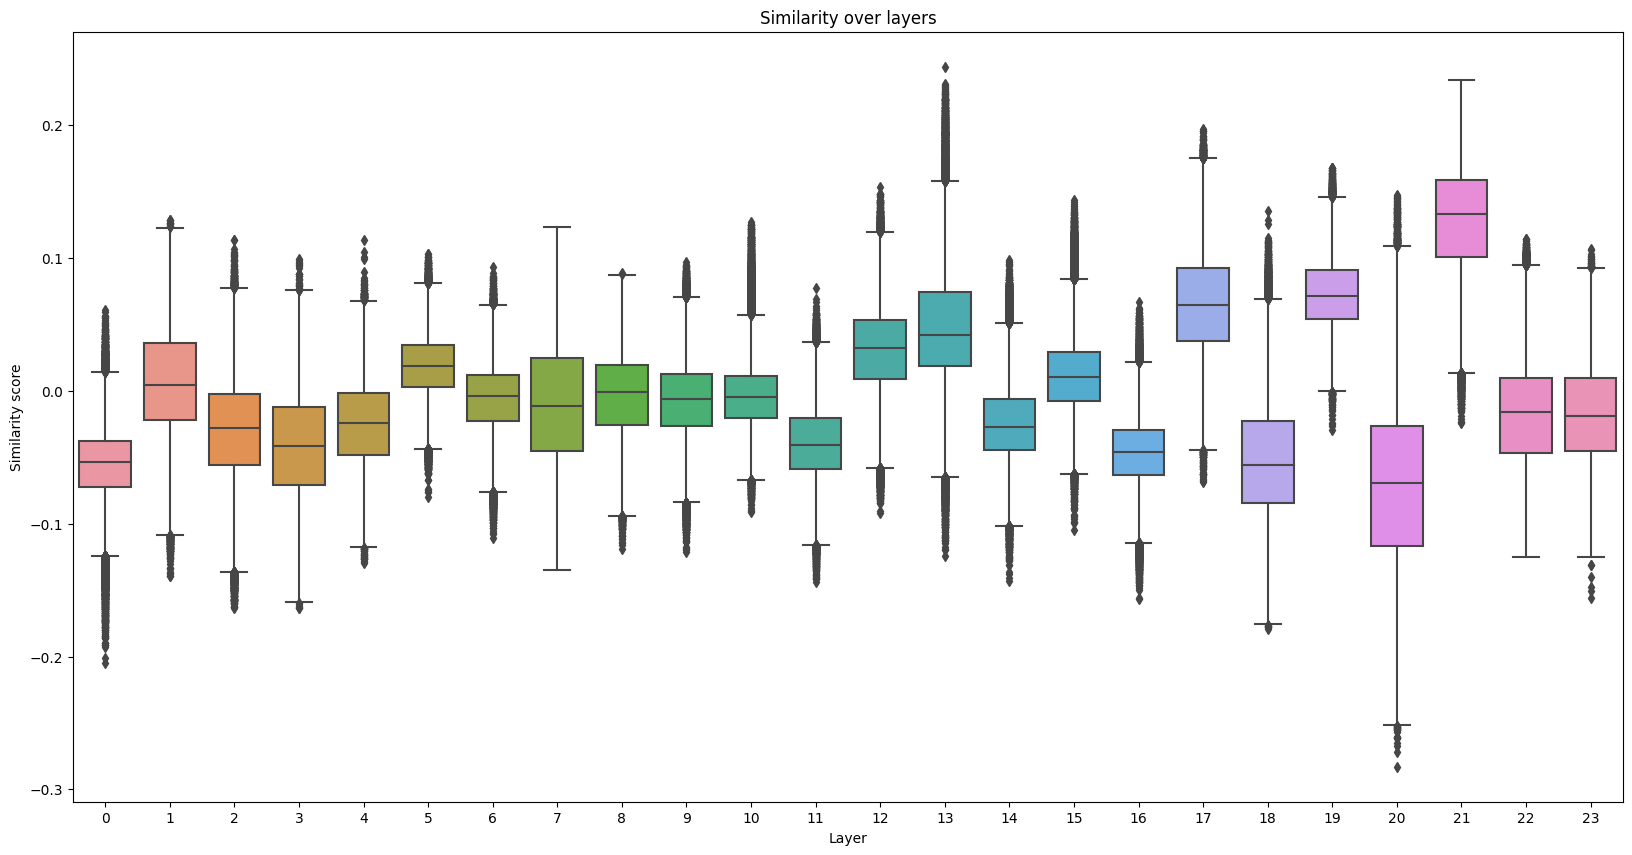

/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/users/gmongaras/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

Text(0.5, 1.0, 'Similarity over layers')

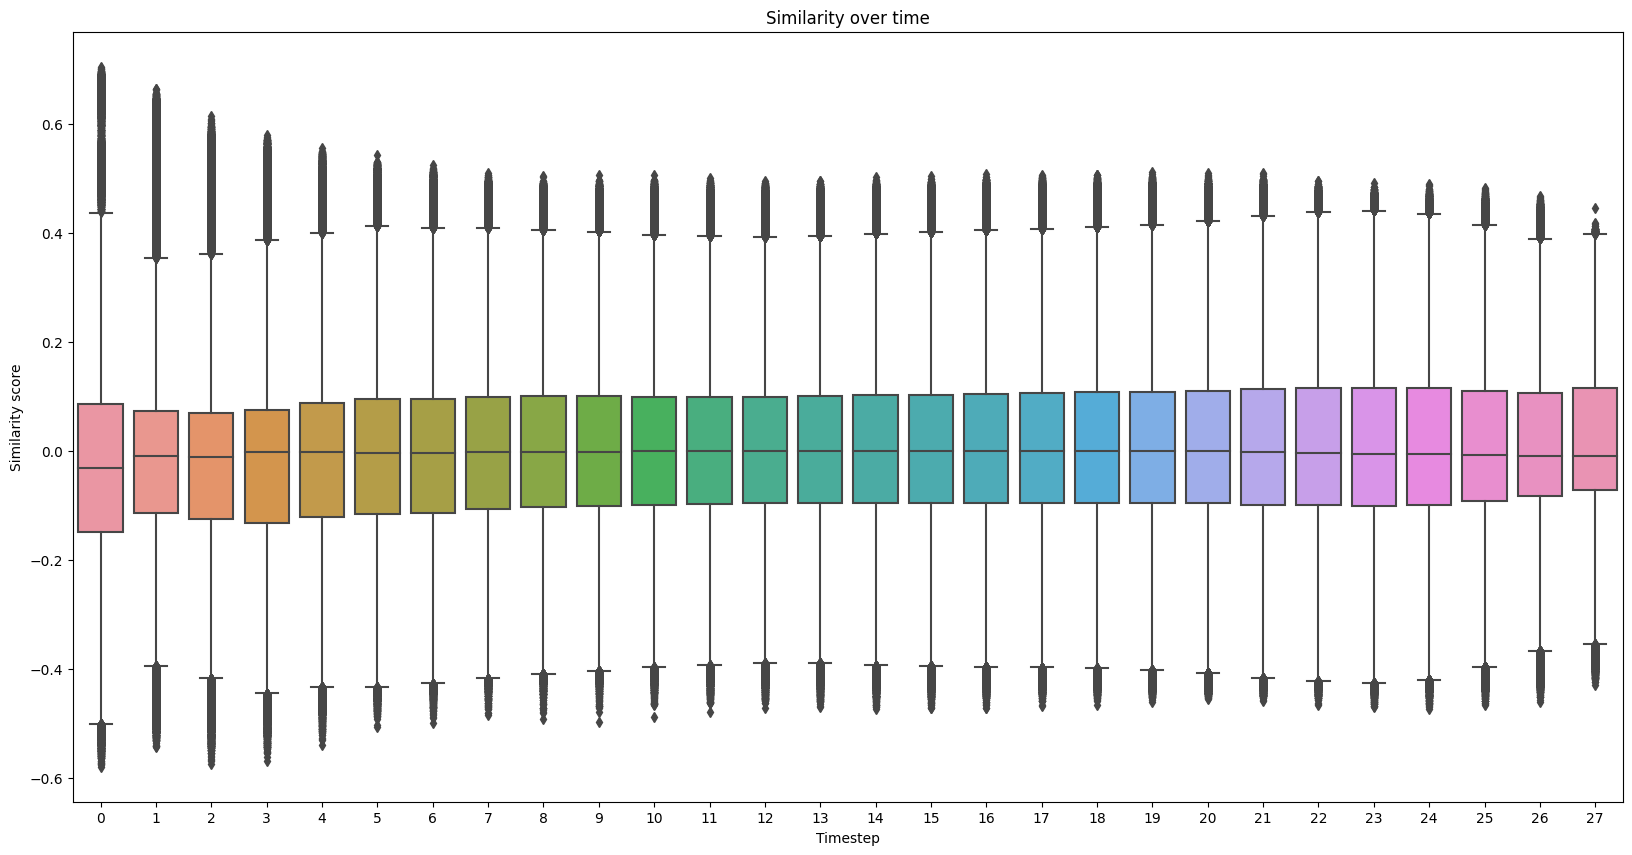

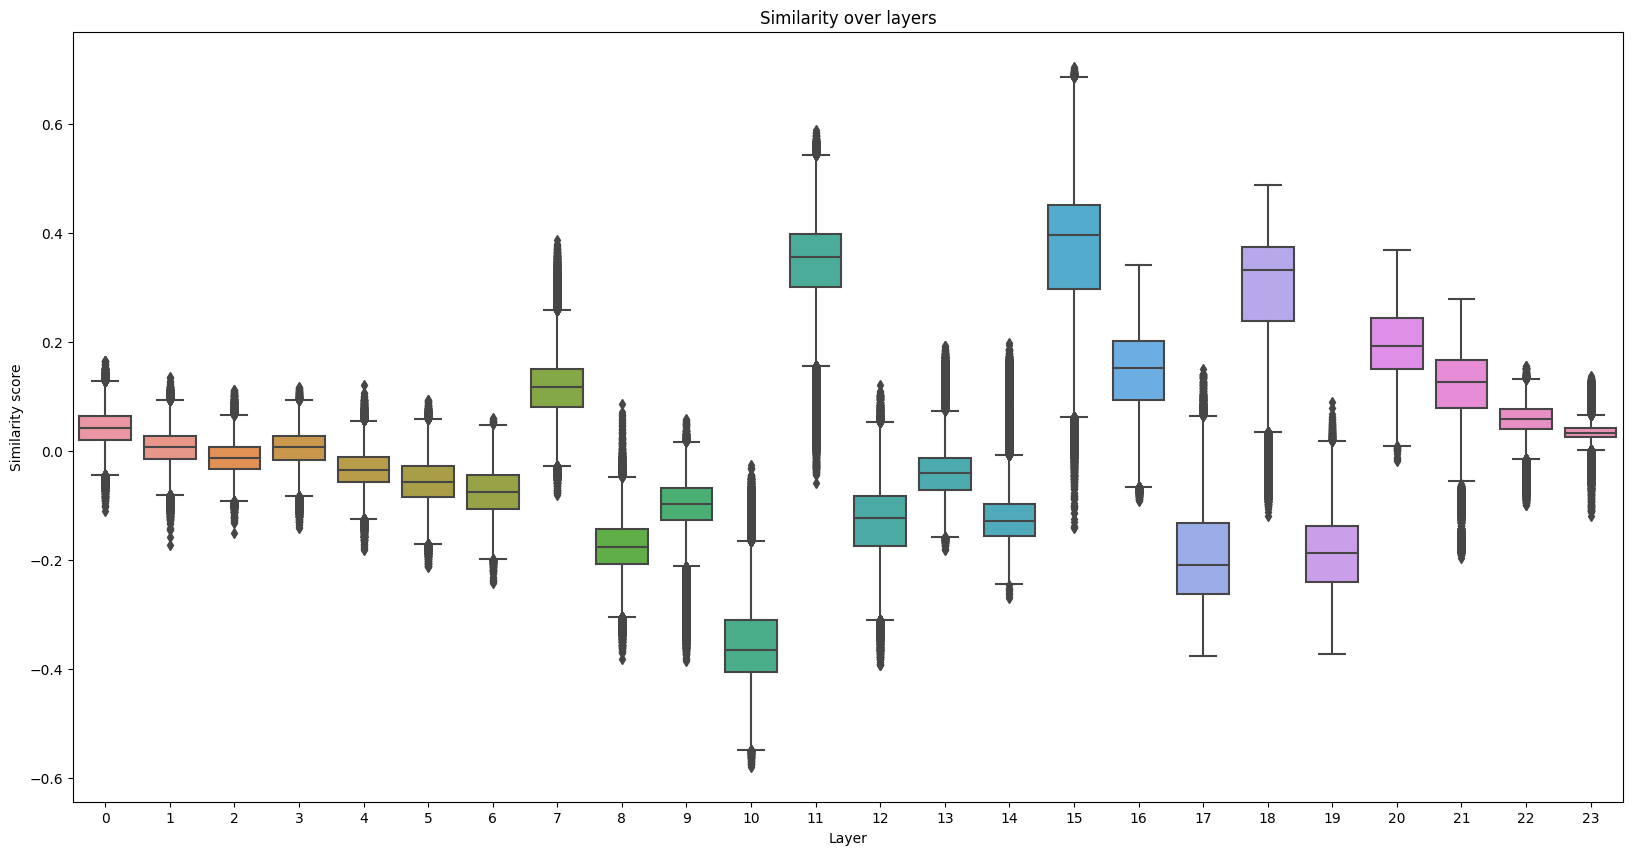

In [24]:
# Plot similarity over time
plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(similarity_over_time.mT.cpu().numpy()))
plt.xlabel("Timestep")
plt.ylabel("Similarity score")
plt.title("Similarity over time")
plt.show()

# Plot similarity over layers
plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(similarity_over_layers.mT.cpu().numpy()))
plt.xlabel("Layer")
plt.ylabel("Similarity score")
plt.title("Similarity over layers")
plt.show()


# Plot similarity over time
plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(similarity_over_time_ff.mT.cpu().numpy()))
plt.xlabel("Timestep")
plt.ylabel("Similarity score")
plt.title("Similarity over time")

# Plot similarity over layers
plt.figure(figsize=(20, 10))
sns.boxplot(data=pd.DataFrame(similarity_over_layers_ff.mT.cpu().numpy()))
plt.xlabel("Layer")
plt.ylabel("Similarity score")
plt.title("Similarity over layers")